Hands-on Code Implementation of the Chapter 05 of 'Build LLM From Scratch'.

In [1]:
#! pip install typing_extensions<4.6.0 -U --force-reinstall

In [ ]:
import tiktoken
import torch
import os
import urllib.request
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from importlib.metadata import version
import sys
import numpy as np


In [2]:

packages = ["matplotlib","numpy","tiktoken", "tensorflow","torch"]
for pack in packages:
    print(f'Version for {pack} : {version(pack)}')


Version for matplotlib : 3.9.2
Version for numpy : 1.24.3
Version for tiktoken : 0.7.0
Version for tensorflow : 2.13.1
Version for torch : 2.4.0


In [3]:

sys.path.insert(0, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch04\Transformer_Implementation')
sys.path.insert(1, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch02\Dataloader')
sys.path.insert(2, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch05\CustomGPT_Pretraining')
from gpt2 import GPT2
from dataset_dataloader import GPTCustomDataloader
from text_generation import Text_Generation

In [4]:
GPT2_CONFIG = {
    'vocab_size':50257,
    'embedding_dimension':768,
    'num_heads':12,
    'context_length':256,
    'dropout':0.1,
    'qkv_bias':False,
    'num_layers':12,
    }

torch.manual_seed(123)
gpt_model = GPT2(GPT2_CONFIG)
gpt_model.eval();

In [38]:
#Convert input text into a torch tensor of token list with batch dimension added
def text_to_tokenID(tokenizer, text):
    encoded_ids = []
    if type(text) == str:
        encoded_ids = (tokenizer.encode(text, allowed_special = {'<|endoftext|>'}))
        batch_tok_ids = torch.tensor(encoded_ids).unsqueeze(0)
    else:
        for t in text:
            encoded_ids.append(tokenizer.encode(t, allowed_special = {'<|endoftext|>'}))
            batch_tok_ids = torch.tensor(encoded_ids)
    
    return batch_tok_ids

#Convert input torch tensor of token list with batch dimension to text (without batch dimension)
def tokenID_to_text(tokenizer,batch_tokID):
    token_list = batch_tokID.squeeze(0)
    text = tokenizer.decode(token_list.tolist())
    return text

def generate_text(model, batch_tokenList, max_sequence_length, context_length):

    #Run the loop till generation of max_sequence_length
    for _ in range(max_sequence_length):

        #In case the batch token sequence is greater than the context length of the model, take the last <context_length> tokens for the next iteration:
        b_tokens = batch_tokenList[:, -context_length:]

        #No gradient calculation as model is in evaluation mode:
        with torch.no_grad():
            
            #Model outputs the logit vector of size <batch, input_sequence_length, vocab_size>
            output_logits = model(b_tokens)

        #Consider the last logit vector for next token generation:
        output_logits = output_logits[:, -1, :]

        #Compute the softmax probability for the last logit vector:
        #softmax_probs = torch.softmax(last_logits, dim=-1)

        #Take the token_id corresponding to the maximum probability value
        next_tokenID = torch.argmax(output_logits,dim=-1, keepdim=True)

        #Concat the predicted/generated token id with the input token id list to update it for the next iteration:
        batch_tokenList = torch.cat((batch_tokenList,next_tokenID), dim=1)

    #Return the final output sequence  
    return batch_tokenList

In [7]:
tokenizer = tiktoken.get_encoding("gpt2")
input_text = "Every effort moves you"

print(text_to_tokenID(tokenizer,input_text))

output_tokenList = generate_text(model=gpt_model, batch_tokenList=text_to_tokenID(tokenizer,input_text), 
                                 max_sequence_length=10, context_length=GPT2_CONFIG['context_length'])

output_text = tokenID_to_text(tokenizer, output_tokenList)

print('Output Token List : ', output_tokenList)
print('Output Text::\n', output_text)

tensor([[6109, 3626, 6100,  345]])
Output Token List :  tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])
Output Text::
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [8]:
input_logits = text_to_tokenID(tokenizer, ["every effort moves","I really like"])
target_logits = text_to_tokenID(tokenizer, [" effort moves you", " really like chocolate"])
print(f'Input Logits:\n{input_logits} \nInput Shape: {input_logits.shape}\n')
print(f'Target Logits:\n{target_logits} \nTarget Shape: {target_logits.shape}')


Input Logits:
tensor([[16833,  3626,  6100],
        [   40,  1107,   588]]) 
Input Shape: torch.Size([2, 3])

Target Logits:
tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]]) 
Target Shape: torch.Size([2, 3])


In [9]:
#Negative Average Log Likelihood Loss (NLLLoss) - From Scratch Implementation
def neg_avg_logLikelyhood_loss(output_logits, target_logits):
    
    #Get the batch length value from the output logit tensor:
    batch_length = output_logits.shape[0]
    
    #Compute Softmax Probabilities of the output logit vector
    softmax_probs = torch.softmax(output_logits, dim=-1)
    
    #Get the probabilities corresponding to the target token id for each batch.
    target_probs = []
    for i in range(batch_length):
        target_probs.append(softmax_probs[i, [0,1,2], target_logits[i]])
    
    #Concatenate the probabilities of each batch into 1 tensor
    batch_concatenate = torch.cat((target_probs[0],target_probs[1]))
    
    #Compute the log of the target probabilites
    log_probs = torch.log(batch_concatenate)
    
    #Get the mean for the batch
    avg_log_probs = torch.mean(log_probs)
    
    #Take the negative of the average
    neg_avg_log_probs = -1 * avg_log_probs

    #Perplexity is computed by taking exponential of the loss
    perplexity = torch.exp(neg_avg_log_probs)

    #Return the NLLLoss and Perplexity value
    return neg_avg_log_probs, perplexity


#Cross - Entropy Loss (or NLLLoss) computation - Pytorch's implementation
def torch_ce_loss(output_logits, target_logits):

    #Output logits are 3D tensor of size <b,context_length, vocab_size> --> Roll the first 2 dimension together to get 2D tensor of size <b*context_length, vocab_size>
    output_logits = output_logits.flatten(0,1)

    #Target logits (or Target Token tensor) are 2D tensor of <batch, context_length> --> Roll it to form a 1D tensor of size <b*context_length>
    target_logits = target_logits.flatten()

    #Using CE loss
    ce_loss = torch.nn.functional.cross_entropy(output_logits,target_logits )

    #Perplexity
    perplexity = torch.exp(ce_loss)

    #Return the CELoss and Perplexity value
    return ce_loss,perplexity

In [10]:
with torch.no_grad():
    output_logits = gpt_model(input_logits)

#Checking if the From Scratch Implementation is correctly done by comparing the loss value with Pytorch's CE loss:
ce_loss, perplexity_nll = neg_avg_logLikelyhood_loss(output_logits, target_logits)
torch_celoss, perplexity_ce = torch_ce_loss(output_logits, target_logits)
assert (ce_loss.round()) == (torch_celoss.round())
print(f'Neg_Avg_Log_Likelyhood : {ce_loss}, Cross_Entropy_Loss : {torch_celoss}')
print(f'Perplexity value for NLL : {perplexity_nll}, Perplexity value for CE : {perplexity_ce}')

Neg_Avg_Log_Likelyhood : 10.793963432312012, Cross_Entropy_Loss : 10.793964385986328
Perplexity value for NLL : 48725.7734375, Perplexity value for CE : 48725.8203125


In [11]:
# Downloading the file from the url if it is not present in the directory
file_name = 'the-verdict.txt'
folder_url = 'ch05\01_main-chapter-code\the-verdict.txt'
web_url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
if not os.path.exists(folder_url):
    urllib.request.urlretrieve(web_url,file_name)

In [12]:
with open(file_name, "r" , encoding="utf-8") as f:
    input_file = f.read()

print('Total characters present in the demo training file: ', len(input_file))
print('First 100 characters: ', input_file[:100])
print('Last 100 characters: ', input_file[-100:])
print('Total tokens present: ', len(tokenizer.encode(input_file)))

Total characters present in the demo training file:  20479
First 100 characters:  I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g
Last 100 characters:   it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."
Total tokens present:  5145


In [13]:
#Creating the train and test data split
def create_train_test_split(input_text,ratio):
    text_len = len(input_text)
    train_split = input_text[:int(ratio * text_len)]
    test_split = input_text[int(ratio * text_len) :]

    return train_split, test_split

In [14]:
ratio = 0.9
train_split, test_split = create_train_test_split(input_file, ratio=0.9)
print('Train Data Length: ', len(train_split))
print('Test Data Length: ', len(test_split))

Train Data Length:  18431
Test Data Length:  2048


In [15]:
#Creating the train and test dataloaders:
train_dataLoader = GPTCustomDataloader(train_split, context_length=GPT2_CONFIG['context_length'], stride=GPT2_CONFIG['context_length'], batch_size=2,
                                        shuffle=True, drop_last=True,num_workers=0)

test_dataLoader = GPTCustomDataloader(test_split, context_length=GPT2_CONFIG['context_length'], stride=GPT2_CONFIG['context_length'], batch_size=2,
                                        shuffle=True, drop_last=True,num_workers=0)

# Sanity check
if len(tokenizer.encode(input_file)) * (ratio) < GPT2_CONFIG["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if len(tokenizer.encode(input_file)) * (1-ratio) < GPT2_CONFIG["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [16]:
#Print the dataloader contents to confirm correct format:
print('************** TRAIN DATALOADER ****************************')
for x,y in train_dataLoader:
    print(x.shape, y.shape)
print('************** TEST DATALOADER ****************************')
for x,y in test_dataLoader:
    print(x.shape, y.shape)

************** TRAIN DATALOADER ****************************
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
************** TEST DATALOADER ****************************
torch.Size([2, 256]) torch.Size([2, 256])


In [17]:
def generate_text_simple(model, idx, max_new_tokens, context_size, train=False):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx if train else logits

In [ ]:
def loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    output_logits = model(input_batch)
    ce_loss = torch.nn.functional.cross_entropy(output_logits.flatten(0,1), target_batch.flatten())
    return ce_loss

def loss_loader(model, device, dataloader, num_batches = None ):

    batch_loss = 0.0
    if len(dataloader) == 0:
        print('No batches/data in the dataloader..!')
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches,len(dataloader))
        
    for i, (input_batch, target_batch) in enumerate(dataloader):

        if i < num_batches:
            ce_loss = loss_batch(input_batch, target_batch, model, device)
            batch_loss += ce_loss.item()
        else:
            break

    avg_batch_loss = batch_loss / num_batches
    return avg_batch_loss

def evaluate_model(model, device, train_dataLoader, test_dataLoader, num_batches=None):

    model.eval()

    with torch.no_grad():
        train_loss = loss_loader(model, device, train_dataLoader, num_batches)
        test_loss = loss_loader(model, device, test_dataLoader, num_batches)

    model.train()

    return train_loss, test_loss

def generate_print_output(model, device, tokenizer, input_text, train= False):

    model.eval()
    context_length = model.pos_embedding.weight.shape[0]
    batch_tokenList = text_to_tokenID(tokenizer, input_text).to(device)

    with torch.no_grad():
        output_tokList = generate_text_simple(model, 
                                              batch_tokenList, 
                                              max_new_tokens = 50, 
                                              context_size= context_length, train = train)
    print('************ Generation Sample *******************')
    sample_gen_output = tokenID_to_text(tokenizer,output_tokList)
    print(sample_gen_output.replace('\n', ''))
    print('**************************************************')
    model.train()

In [19]:
def train_model(model, optimizer, train_dataLoader, test_dataLoader, device, 
                input_text, num_epochs, eval_batchSize, eval_freq, tokenizer):
    
    train_losses, test_losses, track_tokens_seen = [], [], []

    tokens_seen, global_step = 0, -1

    for ep in range(num_epochs):

        model.train()

        for train_x, train_y in train_dataLoader:

            optimizer.zero_grad()
            loss = loss_batch(train_x, train_y, model, device)
            loss.backward()
            optimizer.step()
            global_step += 1
            tokens_seen += train_x.numel()

            if global_step % eval_freq == 0:

                train_loss, test_loss = evaluate_model(model, device, train_dataLoader, test_dataLoader, eval_batchSize)
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                print(f'Epoch No: {ep+1}, Step: {global_step:06d}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
                print(f'Total Tokens seen till now: {tokens_seen}')
                track_tokens_seen.append(tokens_seen)

        generate_print_output(model, device, tokenizer, input_text, True)

    return train_losses, test_losses, track_tokens_seen

In [20]:
!nvidia-smi


Mon Apr 14 15:57:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              6W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

torch.manual_seed(123)
gpt_model = GPT2(GPT2_CONFIG)
gpt_model.to(device)
optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=0.0004, weight_decay=0.1)

epochs = 10
sample_text = "Every effort moves you"
train_losses, test_losses, track_tokens_seen = train_model(model = gpt_model, optimizer = optimizer, 
                                        train_dataLoader = train_dataLoader, test_dataLoader = test_dataLoader, 
                                        device = device, input_text = sample_text, num_epochs = epochs, 
                                        eval_batchSize = 5, eval_freq = 5, tokenizer = tokenizer)

end_time = time.time()
train_time =(end_time - start_time) / 60
print(f'-------------- Total Training Time : {train_time:.2f} minutes --------------')

Device Available:  cuda
Epoch No: 1, Step: 000000, Train Loss: 9.819, Test Loss: 9.926
Total Tokens seen till now: 512
Epoch No: 1, Step: 000005, Train Loss: 7.924, Test Loss: 8.341
Total Tokens seen till now: 3072
************ Generation Sample *******************
Every effort moves you,,,,,,,,,,,,.
**************************************************
Epoch No: 2, Step: 000010, Train Loss: 6.587, Test Loss: 7.043
Total Tokens seen till now: 5632
Epoch No: 2, Step: 000015, Train Loss: 5.986, Test Loss: 6.593
Total Tokens seen till now: 8192
************ Generation Sample *******************
Every effort moves you, the, and, the, the, the, the.", the, the,,, the, and, the, of the, the, the,, the, the,, the, and, the,, the,
**************************************************
Epoch No: 3, Step: 000020, Train Loss: 15.511, Test Loss: 15.643
Total Tokens seen till now: 10752
Epoch No: 3, Step: 000025, Train Loss: 5.612, Test Loss: 6.459
Total Tokens seen till now: 13312
************ Generation

In [22]:
print(gpt_model)

GPT2(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(256, 768)
  (token_dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.1, inplace=False)
    )

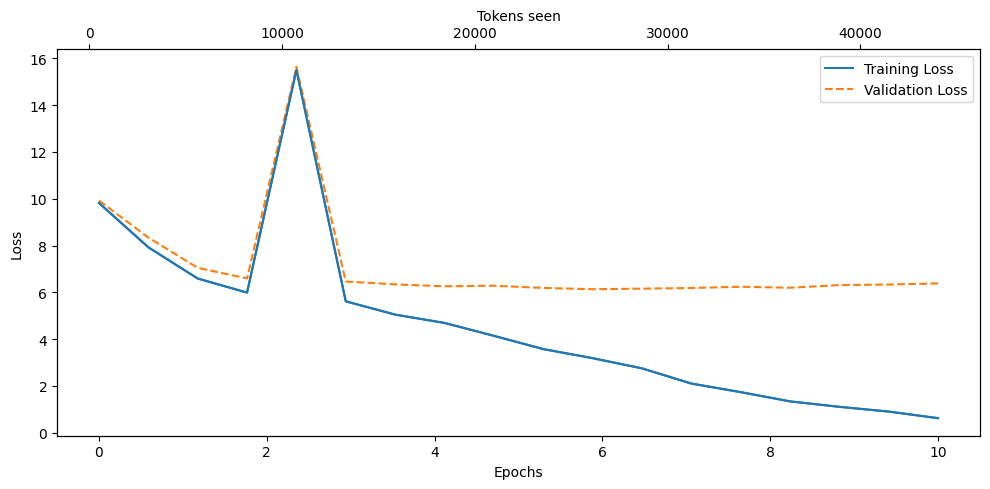

In [23]:
def plot_loss(tokens, epochs, train_loss, val_loss):
    fig, ax = plt.subplots(figsize=(10,5))

    #Epochs vs Loss
    ax.plot(epochs,train_loss,label = 'Training Loss')
    ax.plot(epochs, val_loss, linestyle="--", label = 'Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc="upper right")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    #Token vs Loss
    ax2 = ax.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens, train_loss)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss_token_epochs_preTrain.pdf")
    plt.show()

x = torch.linspace(0, epochs, len(train_losses))
plot_loss(track_tokens_seen, x, train_losses, test_losses)

Device Available:  cuda
ARGMAX (With No Temperature):: 
0 x closer
0 x every
0 x effort
1000 x forward
0 x inches
0 x moves
0 x pizza
0 x toward
0 x you
-------------
None
MULTI_NOMIAL At Temperature ::  1
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


MULTI_NOMIAL At Temperature ::  0.1
0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward
0 x you


MULTI_NOMIAL At Temperature ::  5
153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


-------------


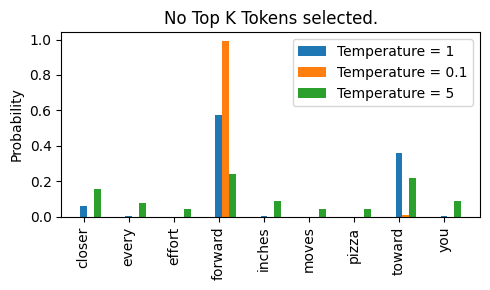

None
MULTI_NOMIAL At Temperature ::  1
0 x closer
0 x every
0 x effort
586 x forward
0 x inches
0 x moves
0 x pizza
414 x toward
0 x you


MULTI_NOMIAL At Temperature ::  0.1
0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward
0 x you


MULTI_NOMIAL At Temperature ::  5
0 x closer
0 x every
0 x effort
501 x forward
0 x inches
0 x moves
0 x pizza
499 x toward
0 x you


-------------


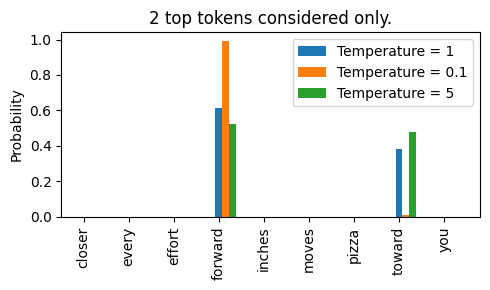

None


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 


def softmax(logits, top_k = None, temperature=None):
    if temperature is None:
        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            logits = torch.where(condition = 
                                 logits < top_logits[-1], 
                                 input = torch.tensor(float("-inf")),
                                 other=logits)
            
        probas = torch.softmax(logits, dim=0)
    else:
        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            logits = torch.where(condition = 
                                 logits < top_logits[-1], 
                                 input = torch.tensor(float("-inf")),
                                 other=logits)
        scaled_logits = logits / temperature
        probas = torch.softmax(scaled_logits, dim=0)
    return probas 

def token_fre(probas, temp, top_k):
    x = torch.arange(len(vocab))
    bar_width = 0.15
    fig, ax = plt.subplots(figsize=(5, 3))

    for i, T in enumerate(temp):
        rects = ax.bar(x + i * bar_width, probas[i], bar_width, label=f'Temperature = {T}')

    ax.set_ylabel('Probability')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab.keys(), rotation=90)
    ax.set_title('No Top K Tokens selected.' if top_k is None else str(top_k)+' top tokens considered only.')
    ax.legend()

    plt.tight_layout()
    plt.savefig("temperature-plot_handson.pdf")
    plt.show()


def eval_token_freuency(model, device,tokenizer, vocab, input_text, iter, max_new_tokens, context_size, top_k = None,temperature= None, multiNomial = False):
    inverse_vocab = {v: k for k, v in vocab.items()}
    model.to(device)
    model.eval()
    tok_list = text_to_tokenID(tokenizer, input_text).to(device)

    #If running on entire vocab then uncomment the below line. Else: for dummy vocab use the pre-defined logits
    #logits = generate_text_simple(model,tok_list, max_new_tokens=max_new_tokens, context_size=context_size, train=False)

    logits= torch.tensor( [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

    if temperature is None:
        probas = softmax(logits, top_k, temperature)

        if multiNomial:
            print('MULTI_NOMIAL (With No Temperature):: ')
            torch.manual_seed(123)
            sample = [torch.multinomial(probas, num_samples=1).item() for i in range(iter)]
        else:
            print('ARGMAX (With No Temperature):: ')
            sample = [torch.argmax(probas).item() for i in range(iter)]
        
        sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
        for i, freq in enumerate(sampled_ids):
            print(f"{freq} x {inverse_vocab[i]}")
        print('-------------')
    else:
        probas_list = []
        for T in temperature:
            probas = softmax(logits, top_k, T)
            probas_list.append(probas)

            if multiNomial:
                print('MULTI_NOMIAL At Temperature :: ', T)
                torch.manual_seed(123)
                sample = [torch.multinomial(probas, num_samples=1).item() for i in range(iter)]
            else:
                print('ARGMAX At Temperature :: ', T)
                sample = [torch.argmax(probas).item() for i in range(iter)]
            
            sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
            for i, freq in enumerate(sampled_ids):
                print(f"{freq} x {inverse_vocab[i]}")
            print('\n')   
        print('-------------')
        token_fre(probas_list, temperature, top_k)    
        

iter = 1000
max_new_tokens = 25
input_text = "Every effort moves you"
print(eval_token_freuency(gpt_model, device,tokenizer, vocab, input_text, iter, max_new_tokens, GPT2_CONFIG['context_length'], top_k = None,
                          temperature=None,multiNomial = False))
temperatures = [1, 0.1, 5]
print(eval_token_freuency(gpt_model, device, tokenizer, vocab, input_text, iter, max_new_tokens, GPT2_CONFIG['context_length'], top_k = None, 
                          temperature=temperatures,multiNomial = True))
top_k = 2
print(eval_token_freuency(gpt_model, device, tokenizer, vocab, input_text, iter, max_new_tokens, GPT2_CONFIG['context_length'], top_k, 
                          temperature=temperatures,multiNomial = True))

In [36]:
def text_generation(model, idx, max_new_tokens, context_size, temp=1.0, top_k= None, eos_id = None, train=False):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        #Get the top_k tokens:
        if top_k is not None:

            # Get the top k tokens from the logits vector
            top_logits, _ = torch.topk(logits, top_k)
            
            # Mask out values of all other location (apart from those of top k) with -infinity value so that softmax is not applied on them later.
            logits = torch.where(condition= logits < top_logits[:, -1],
                                 input= torch.tensor(float("-inf")).to(logits.device),
                                 other= logits)
             
        #Get the temperature scaled logits:
        if temp > 0.0:

            #Scale the logits according to the temperature value:
            scaled_logits = logits / temp

            #Get the softmax probabilities on the scaled logits
            probas = torch.softmax(scaled_logits, dim=-1)

            #Get the next token prediction sampled on a multinomial distribution
            idx_next = torch.multinomial(probas, num_samples=1)
        
        else:

            # Get the idx of the vocab entry with the highest logits value
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        #If end of seuence token id is provided, stop generating if that token id is predicted
        if idx_next == eos_id:
            break
 
        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [33]:
def generate_print(model, device, tokenizer, input_text, temp=1.0, top_k= None, eos_id = None, train= False):
    model.eval()
    context_length = model.pos_embedding.weight.shape[0]
    batch_tokenList = text_to_tokenID(tokenizer, input_text).to(device)

    with torch.no_grad():
        output_tokList = text_generation(model,batch_tokenList, 
                                              max_new_tokens = 50, 
                                              context_size= context_length, 
                                              temp=temp, top_k= top_k, eos_id = eos_id,
                                              train = train)
        
    print('************ Generation Sample *******************')
    sample_gen_output = tokenID_to_text(tokenizer,output_tokList)
    print(sample_gen_output.replace('\n', ''))
    print('**************************************************')
    model.train()

In [42]:
def train_model_tempTopKScaled(model, optimizer, train_dataLoader, test_dataLoader, device, 
                input_text, num_epochs, eval_batchSize, eval_freq, tokenizer, temp=1.0, top_k= None, eos_id = None):
    
    train_losses, test_losses, track_tokens_seen = [], [], []

    tokens_seen, global_step = 0, -1

    for ep in range(num_epochs):

        model.train()

        for train_x, train_y in train_dataLoader:

            optimizer.zero_grad()
            loss = loss_batch(train_x, train_y, model, device)
            loss.backward()
            optimizer.step()
            global_step += 1
            tokens_seen += train_x.numel()

            if global_step % eval_freq == 0:

                train_loss, test_loss = evaluate_model(model, device, train_dataLoader, test_dataLoader, eval_batchSize)
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                print(f'Epoch No: {ep+1}, Step: {global_step:06d}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
                print(f'Total Tokens seen till now: {tokens_seen}')
                track_tokens_seen.append(tokens_seen)

        generate_print(model, device, tokenizer, input_text, temp, top_k, eos_id, train = True)

    return train_losses, test_losses, track_tokens_seen

In [43]:
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

torch.manual_seed(123)
gpt_model = GPT2(GPT2_CONFIG)
gpt_model.to(device)
optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=0.0004, weight_decay=0.1)

epochs = 10
sample_text = "Every effort moves you"
train_losses, test_losses, track_tokens_seen = train_model_tempTopKScaled(model = gpt_model, optimizer = optimizer, 
                                        train_dataLoader = train_dataLoader, test_dataLoader = test_dataLoader, 
                                        device = device, input_text = sample_text, num_epochs = epochs, 
                                        eval_batchSize = 5, eval_freq = 5, tokenizer = tokenizer, temp=0.1, top_k= 3, eos_id = None)

end_time = time.time()
train_time =(end_time - start_time) / 60
print(f'-------------- Total Training Time : {train_time:.2f} minutes --------------')

Device Available:  cuda
Epoch No: 1, Step: 000000, Train Loss: 9.819, Test Loss: 9.926
Total Tokens seen till now: 512
Epoch No: 1, Step: 000005, Train Loss: 7.924, Test Loss: 8.341
Total Tokens seen till now: 3072
************ Generation Sample *******************
Every effort moves you,,,,.
**************************************************
Epoch No: 2, Step: 000010, Train Loss: 6.587, Test Loss: 7.044
Total Tokens seen till now: 5632
Epoch No: 2, Step: 000015, Train Loss: 5.986, Test Loss: 6.593
Total Tokens seen till now: 8192
************ Generation Sample *******************
Every effort moves you, the, and, the.", the, and, the, and, and, the, the, and, the, of the,, the, and, the, the,, the, and, the,, the,
**************************************************
Epoch No: 3, Step: 000020, Train Loss: 15.493, Test Loss: 15.616
Total Tokens seen till now: 10752
Epoch No: 3, Step: 000025, Train Loss: 5.578, Test Loss: 6.442
Total Tokens seen till now: 13312
************ Generation Samp

In [ ]:
# Save the model and optimizer state dicts:
torch.save({
    'model_state_dict': gpt_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    },
    "model_and_optimizer_PreTrain.pth"
    )


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

#Define the checkpoint to load the model and optimizer from:
checkpoint = torch.load("model_and_optimizer_PreTrain.pth", map_location= device, weights_only= True)


#Initialise the model with the config file:
torch.manual_seed(123)
gpt2 = GPT2(GPT2_CONFIG)

#Load the weights in the new model instance
gpt2.load_state_dict(checkpoint['model_state_dict'])
gpt2.to(device)


#Initialise the optimizer:
optim = torch.optim.AdamW(gpt2.parameters(), lr=0.0004, weight_decay=0.1)

#Load the optimizer weights
optim.load_state_dict(checkpoint['optimizer_state_dict'])

print('Model and Optimizer is loaded properly..!')

Device Available:  cuda
Model and Optimizer is loaded properly..!


In [ ]:
# Train the model for 1 epoch more to see if the save and load function worked properly:
start_time = time.time()
gpt2.train()
epochs = 1
sample_text = "Every effort moves you"
train_losses, test_losses, track_tokens_seen = train_model_tempTopKScaled(model = gpt2, optimizer = optim, 
                                        train_dataLoader = train_dataLoader, test_dataLoader = test_dataLoader, 
                                        device = device, input_text = sample_text, num_epochs = epochs, 
                                        eval_batchSize = 5, eval_freq = 5, tokenizer = tokenizer, temp=0.1, top_k= 3, eos_id = None)

end_time = time.time()
train_time =(end_time - start_time) / 60
print(f'-------------- Total Training Time : {train_time:.2f} minutes --------------')


Epoch No: 1, Step: 000000, Train Loss: 0.501, Test Loss: 6.459
Total Tokens seen till now: 512
Epoch No: 1, Step: 000005, Train Loss: 0.305, Test Loss: 6.508
Total Tokens seen till now: 3072
************ Generation Sample *******************
Every effort moves you?""Yes--quite insensible to the irony. She wanted him vindicated--and by me!"He laughed again, and threw back the window-curtains, as I turned, when Stroud laid in the first
**************************************************
-------------- Total Training Time : 0.34 minutes --------------


##### Run the below cells in order to load the OpenAI's weight into our GPT2's instance.

In [6]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.13.1
tqdm version: 4.66.6


In [4]:
# Using the function "download_and_load_gpt2" as is given in the book "Build LLM From Scratch"

from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [5]:
# Model configs:
GPT2_CONFIG = {
    'vocab_size':50257,
    'embedding_dimension':768,
    'num_heads':12,
    'context_length':256, #We used a smaller context length till now to do uick training of the model to make sure the code is working properly.
    'dropout':0.1,
    'qkv_bias':False,
    'num_layers':12,
    }


gpt2_model_configs = {
    "gpt2_124M" : {'embedding_dimension':768, 'num_heads':12, 'num_layers':12},
    "gpt2_355M" : {'embedding_dimension':1024, 'num_heads':16, 'num_layers':24},
    "gpt2_774M" : {'embedding_dimension':1280, 'num_heads':20, 'num_layers':36},
    "gpt2_1558M" : {'embedding_dimension':1600, 'num_heads':25, 'num_layers':48},
}

updatedGPT2_CONFIG = GPT2_CONFIG.copy()
model_name = "gpt2_124M"
updatedGPT2_CONFIG.update(gpt2_model_configs[model_name])
updatedGPT2_CONFIG.update({'qkv_bias':True, 'context_length':1024}) #Updating these parameters as according to what OpenAI used to train GPT2 124(M) Model \
                                                                    #to load the weights properly

gpt2_preTrained = GPT2(updatedGPT2_CONFIG)
gpt2_preTrained.eval()

GPT2(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(1024, 768)
  (token_dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.1, inplace=False)
    )
 

In [11]:
#Exploring the settings and params dictionary that contains all the weight vectors::
print('Settings:: ',settings)
print('Parameters::', params.keys())
print('Transformer Blocks:: ', params['blocks'][0].keys()) 
print('Attention Blocks:: ', params['blocks'][0]['attn'].keys())
print('Contextual Attention (Q, K, V) Blocks (bias, weights) :: ', params['blocks'][0]['attn']['c_attn'].keys())
print('Contextual Projection (out_proj) Layer (bias, weights) :: ', params['blocks'][0]['attn']['c_proj'].keys())
print('FeedForward Blocks:: ', params['blocks'][0]['mlp'].keys())
print('Layer Normalization Blocks:: ', params['blocks'][0]['ln_1'].keys())
print('Shift (beta) Weights of Final LayerNormalization Block:: ', len(params['b']))
print('Scale (gamma) Weights of Final LayerNormalization Block :: ',len(params['g']))
print('Total Postional Embeddings Weight Vectors are {0}, Size of each vector is {1}. '.format(len(params['wpe']), len(params['wpe'][0])))
print('Total Token Embeddings Weight Vectors are {0}, Size of each vector is {1}. '.format(len(params['wte']), len(params['wte'][0])))

Settings::  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameters:: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
Transformer Blocks::  dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])
Attention Blocks::  dict_keys(['c_attn', 'c_proj'])
Contextual Attention (Q, K, V) Blocks (bias, weights) ::  dict_keys(['b', 'w'])
Contextual Projection (out_proj) Layer (bias, weights) ::  dict_keys(['b', 'w'])
FeedForward Blocks::  dict_keys(['c_fc', 'c_proj'])
Layer Normalization Blocks::  dict_keys(['b', 'g'])
Shift (beta) Weights of Final LayerNormalization Block::  768
Scale (gamma) Weights of Final LayerNormalization Block ::  768
Total Postional Embeddings Weight Vectors are 1024, Size of each vector is 768. 
Total Token Embeddings Weight Vectors are 50257, Size of each vector is 768. 


##### Load OpenAI's GPT2 (124M) weights into our instance of GPT2 model

In [6]:
def assign_weights(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [7]:
def gpt2_loadedWeights(gpt2, params):

    #Load the weights for the token embedding and postitional embedding layers:
    gpt2.token_embedding.weight = assign_weights(gpt2.token_embedding.weight, params['wte'])
    gpt2.pos_embedding.weight = assign_weights(gpt2.pos_embedding.weight, params['wpe'])

    #Load the weights for the transformer blocks:
    for block in range(len(params['blocks'])):

        #-------------------Split an array into multiple sub-arrays as views : Splitting the weights matrix -----------------------
        q_weight, k_weight, v_weight = np.split(params['blocks'][block]['attn']['c_attn']['w'],3, axis = -1)

        #Load the weights into the Query matrix of each blocks:
        gpt2.transformer_block[block].attention_block.W_query.weight = assign_weights(gpt2.transformer_block[block].attention_block.W_query.weight, 
                                                                                      q_weight.T)
        
        #Load the weights into the Key matrix of each blocks:
        gpt2.transformer_block[block].attention_block.W_key.weight = assign_weights(gpt2.transformer_block[block].attention_block.W_key.weight, 
                                                                                      k_weight.T)
        
        #Load the weights into the Value matrix of each blocks:
        gpt2.transformer_block[block].attention_block.W_value.weight = assign_weights(gpt2.transformer_block[block].attention_block.W_value.weight, 
                                                                                      v_weight.T)
        

        #----------------- Splitting the bias matrix --------------------------------------------------------------------------------
        q_bias, k_bias, v_bias = np.split(params['blocks'][block]['attn']['c_attn']['b'],3, axis = -1)

        #Load the bias into the Query matrix of each blocks:
        gpt2.transformer_block[block].attention_block.W_query.bias = assign_weights(gpt2.transformer_block[block].attention_block.W_query.bias, 
                                                                                      q_bias)
        
        #Load the bias into the Key matrix of each blocks:
        gpt2.transformer_block[block].attention_block.W_key.bias = assign_weights(gpt2.transformer_block[block].attention_block.W_key.bias, 
                                                                                      k_bias)
        
        #Load the bias into the Value matrix of each blocks:
        gpt2.transformer_block[block].attention_block.W_value.bias = assign_weights(gpt2.transformer_block[block].attention_block.W_value.bias, 
                                                                                      v_bias)
        


        #----------------- Loading the projection layer weights present inside each attention block ---------------------------------
        #Load the weights into the Output Projection layer of each blocks:
        gpt2.transformer_block[block].attention_block.out_projection.weight = assign_weights(gpt2.transformer_block[block].attention_block.out_projection.weight, 
                                                                                      params['blocks'][block]['attn']['c_proj']['w'].T)
        
        #Load the bias into the Output Projection layer of each blocks:
        gpt2.transformer_block[block].attention_block.out_projection.bias = assign_weights(gpt2.transformer_block[block].attention_block.out_projection.bias, 
                                                                                      params['blocks'][block]['attn']['c_proj']['b'])
        

        #----------------- Loading the FeedForward Block weights and bias present inside each Transformer block ---------------------------------
        #Load the weights into the 1st FC layer:
        gpt2.transformer_block[block].feedForward.block[0].weight = assign_weights(gpt2.transformer_block[block].feedForward.block[0].weight, 
                                                                                      params['blocks'][block]['mlp']['c_fc']['w'].T)
        
        #Load the bias into the 1st FC layer:
        gpt2.transformer_block[block].feedForward.block[0].bias = assign_weights(gpt2.transformer_block[block].feedForward.block[0].bias, 
                                                                                      params['blocks'][block]['mlp']['c_fc']['b'])
        
        #Load the weights into the 2st FC layer:
        gpt2.transformer_block[block].feedForward.block[2].weight = assign_weights(gpt2.transformer_block[block].feedForward.block[2].weight, 
                                                                                      params['blocks'][block]['mlp']['c_proj']['w'].T)
        
        #Load the bias into the 2st FC layer:
        gpt2.transformer_block[block].feedForward.block[2].bias = assign_weights(gpt2.transformer_block[block].feedForward.block[2].bias, 
                                                                                      params['blocks'][block]['mlp']['c_proj']['b'])
        

        #----------------- Loading the LayerNormalization Block SCALE and SHIFT values present inside each Transformer block ---------------------------------
        #Load the weights into the 1st LayerNorm layer:
        gpt2.transformer_block[block].layer_norm_attention.scale = assign_weights(gpt2.transformer_block[block].layer_norm_attention.scale, 
                                                                                      params['blocks'][block]['ln_1']['g'])
        
        #Load the bias into the 1st LayerNorm layer:
        gpt2.transformer_block[block].layer_norm_attention.shift = assign_weights(gpt2.transformer_block[block].layer_norm_attention.shift, 
                                                                                      params['blocks'][block]['ln_1']['b'])
        
        #Load the weights into the 2nd LayerNorm layer:
        gpt2.transformer_block[block].layer_norm_feedforward.scale = assign_weights(gpt2.transformer_block[block].layer_norm_feedforward.scale, 
                                                                                      params['blocks'][block]['ln_2']['g'])
        
        #Load the bias into the 2nd LayerNorm layer:
        gpt2.transformer_block[block].layer_norm_feedforward.shift = assign_weights(gpt2.transformer_block[block].layer_norm_feedforward.shift, 
                                                                                      params['blocks'][block]['ln_2']['b'])
        

    #----------------- Loading the FINAL LayerNormalization Block SCALE and SHIFT values  ---------------------------------------------------------------------
    gpt2.final_layerNorm.scale = assign_weights(gpt2.final_layerNorm.scale, params['g'])
    gpt2.final_layerNorm.shift = assign_weights(gpt2.final_layerNorm.scale, params['b'])

    #----------------- Loading the FINAL Projection Block weights  ---------------------------------------------------------------------
    gpt2.final_projection.weight = assign_weights(gpt2.final_projection.weight, params['wte'])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

#Load the weights from OpenAI GPT2 to our instance:
gpt2_loadedWeights(gpt2_preTrained, params)
gpt2_preTrained.to(device);

Device Available:  cuda


In [40]:
tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)

token_ids = generate_print(
    model=gpt2_preTrained,
    device= device,
    tokenizer = tokenizer,
    input_text = "Every effort moves you",
    temp=1.5,
    top_k= 3,
    eos_id = None,
    train= False
    )

************ Generation Sample *******************
Every effort moves you along the road to the top, where the best of your talent is. You'll be rewarded for it with a great job, and you'll have a chance to make a name for yourself as a professional wrestler. You'll be rewarded with an opportunity
**************************************************


In [14]:
generate = Text_Generation(model=gpt2_preTrained, device=device, tokenizer_model='gpt2')
output_text = generate.text_generation(input_text = "Every effort moves you", max_new_tokens=100, temp=1.5,top_k= 3, eos_id = None)
print(output_text)
print('---------------------')
print('Checking the deterministic uality of generation if temperature is set to 0.')
output_text = generate.text_generation(input_text = "Every effort moves you", max_new_tokens=100, temp=0.0,top_k= None, eos_id = None)
print(output_text)
output_text1 = generate.text_generation(input_text = "Every effort moves you", max_new_tokens=100, temp=0.0,top_k= None, eos_id = None)
print(output_text1)

Every effort moves you forward, but the next step is the one that you need to make.You have the opportunity to make the most impact on the world, but the next step is the one you need to make.You have the opportunity to make a big impact on the world, but the next step is the one that your life depends on.You need to make the most impact on the world.You have the opportunity to make the biggest impact on the world.
---------------------
Checking the deterministic uality of generation if temperature is set to 0.
Every effort moves you forward.The first step is to understand the importance of your work.The second step is to understand the importance of your work.The third step is to understand the importance of your work.The fourth step is to understand the importance of your work.The fifth step is to understand the importance of your work.The sixth step is to understand the importance of your work.The seventh step is to understand the importance of your work.
Every effort moves you forw